In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler

In [2]:
def bal_acc(y_true,y_pred,weights=None):
    #weights should be provided as list of weights for each class to sum up to 1
    temp1=np.unique(y_true,return_counts=True)[1]
    temp2=confusion_matrix(y_true,y_pred)
    acc_bal=np.sum(np.diag(temp2)*(temp1/np.sum(temp1))/temp1)
    if len(weights)==0:
        acc_weig=acc_bal
    elif len(weights)!=len(temp1):
        print('provide weight for each class')
    else:
        acc_weig=np.sum(np.diag(temp2)*weights/temp1)
    return (acc_weig,acc_bal)

Loading data

In [3]:
train=pd.read_csv(os.path.join(os.getcwd(),'train.csv.zip'))
#test=pd.read_csv(os.path.join(os.getcwd(),'test.csv.zip'))

In [4]:
#class_weights={1: 0.37062, 2: 0.49657,3:0.05947,4:0.018,5:0.018,6:0.018,7:0.018}
class_weights={1: 0.37053, 2: 0.49657,3:0.05947,4:0.00106,5:0.01287,6:0.02698,7:0.03238}
list_weight=compute_class_weight(class_weights,np.unique(train['Cover_Type']),train['Cover_Type'])

In [5]:
def bal_acc2(y_true,y_pred):
    #weights should be provided as list of weights for each class to sum up to 1
    temp1=np.unique(y_true,return_counts=True)[1]
    temp2=confusion_matrix(y_true,y_pred)
    acc_bal=np.sum(np.diag(temp2)*(temp1/np.sum(temp1))/temp1)
    weights=[0.37053, 0.49657, 0.05947, 0.00106, 0.01287, 0.02698, 0.03238]
    acc_weig=np.sum(np.diag(temp2)*weights/temp1)
    return (acc_weig)

In [6]:
from sklearn.metrics import fbeta_score, make_scorer
my_score = make_scorer(bal_acc2)

In [7]:
#columns
target_col='Cover_Type'
soil_type=[x for x in train.columns if 'Soil' in x]
wild_type=[x for x in train.columns if 'Wilderness' in x]
vert_dist=['Vertical_Distance_To_Hydrology']
hor_dist=['Horizontal_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',  'Horizontal_Distance_To_Fire_Points']
hill_feat=['Hillshade_9am', 'Hillshade_Noon','Hillshade_3pm']
other_feat=['Elevation', 'Aspect', 'Slope']

In [8]:
soil_names = {
0: 'Cathedral family - Rock outcrop complex, extremely stony.',
1: 'Vanet - Ratake families complex, very stony.',
2: 'Haploborolis - Rock outcrop complex, rubbly.',
3: 'Ratake family - Rock outcrop complex, rubbly.',
4: 'Vanet family - Rock outcrop complex complex, rubbly.',
5: 'Vanet - Wetmore families - Rock outcrop complex, stony.',
6: 'Gothic family.',
7: 'Supervisor - Limber families complex.',
8: 'Troutville family, very stony.',
9: 'Bullwark - Catamount families - Rock outcrop complex, rubbly.',
10: 'Bullwark - Catamount families - Rock land complex, rubbly.',
11: 'Legault family - Rock land complex, stony.',
12: 'Catamount family - Rock land - Bullwark family complex, rubbly.',
13: 'Pachic Argiborolis - Aquolis complex.',
14: 'unspecified in the USFS Soil and ELU Survey.',
15: 'Cryaquolls - Cryoborolis complex.',
16: 'Gateview family - Cryaquolls complex.',
17: 'Rogert family, very stony.',
18: 'Typic Cryaquolls - Borohemists complex.',
19: 'Typic Cryaquepts - Typic Cryaquolls complex.',
20: 'Typic Cryaquolls - Leighcan family, till substratum complex.',
21: 'Leighcan family, tibbll substratum, extremely bouldery.',
22: 'Leighcan family, till substratum - Typic Cryaquolls complex.',
23: 'Leighcan family, extremely stony.',
24: 'Leighcan family, warm, extremely stony.',
25: 'Granile - Catamount families complex, very stony.',
26: 'Leighcan family, warm - Rock outcrop complex, extremely stony.',
27: 'Leighcan family - Rock outcrop complex, extremely stony.',
28: 'Como - Legault families complex, extremely stony.',
29: 'Como family - Rock land - Legault family complex, extremely stony.',
30: 'Leighcan - Catamount families complex, extremely stony.',
31: 'Catamount family - Rock outcrop - Leighcan family complex, extremely stony.',
32: 'Leighcan - Catamount families - Rock outcrop complex, extremely stony.',
33: 'Cryorthents - Rock land complex, extremely stony.',
34: 'Cryumbrepts - Rock outcrop - Cryaquepts complex.',
35: 'Bross family - Rock land - Cryumbrepts complex, extremely stony.',
36: 'Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.',
37: 'Leighcan - Moran families - Cryaquolls complex, extremely stony.',
38: 'Moran family - Cryorthents - Leighcan family complex, extremely stony.',
39: 'Moran family - Cryorthents - Rock land complex, extremely stony.'}

Feature engeneering

In [9]:
def add_lin(df,soil_type,soil_names,hill_feat):
    #next add names
    df['soil_cat']=np.dot(df[soil_type],np.arange(len(soil_type)).reshape((len(soil_type),1)))
    df["soil_name"]=df['soil_cat'].map(soil_names)
    #add some text features
    #check how stony is the soil
    df['if_rubbly']=df["soil_name"].str.contains(', rubbly')*1
    df['if_stony']=df["soil_name"].str.contains(', stony')*1
    df['if_v_stony']=df["soil_name"].str.contains('very stony')*1
    df['if_e_stony']=df["soil_name"].str.contains('extremely stony')*1
    #check if Rock is in name
    df['if_rock_crop']=df["soil_name"].str.contains('Rock outcrop')*1
    df['if_rock_land']=df["soil_name"].str.contains('Rock land')*1
    df['if_Leighcan']=df["soil_name"].str.contains('Leighcan')*1
    df['if_Cryaquolls']=df["soil_name"].str.contains('Cryaquolls')*1
    df['if_Catamount']=df["soil_name"].str.contains('Catamount')*1
    df['if_Cryorthents']=df["soil_name"].str.contains('Cryorthents')*1  
    #relative distances
    df['Hyd_2_Road']=df['Horizontal_Distance_To_Hydrology']/(df['Horizontal_Distance_To_Roadways']+0.0001+df['Horizontal_Distance_To_Hydrology'])
    df['Hyd_2_Fire']=df['Horizontal_Distance_To_Hydrology']/(df['Horizontal_Distance_To_Fire_Points']+0.0001+df['Horizontal_Distance_To_Hydrology'])
    df['Fire_2_Road']=df['Horizontal_Distance_To_Fire_Points']/(df['Horizontal_Distance_To_Roadways']+0.0001+df['Horizontal_Distance_To_Fire_Points'])
    #add average shade
    df[['Hillshade_9am', 'Hillshade_Noon','Hillshade_3pm']]=df[['Hillshade_9am', 'Hillshade_Noon','Hillshade_3pm']]/25
    df['av_shade']=df[hill_feat].mean(axis=1)
    df['dshade']=(df['Hillshade_9am']-df['Hillshade_3pm'])
    #add sin of Aspect and slope
    df['Sin_Aspect'] = np.sin(np.radians(df['Aspect']))
    df['Sin_Slope'] = np.sin(np.radians(df['Slope']))
    #if below water
    df['if_below']=(df['Vertical_Distance_To_Hydrology']<0)*1
    df['Vertical_Distance_To_Hydrology']=np.abs(df['Vertical_Distance_To_Hydrology'])
    #normilize the data and make sqrt of data
    temp=['Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Hydrology','Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points','Elevation']
    df[temp]=np.sqrt(df[temp])
    return df

In [10]:
train_new=add_lin(train,soil_type,soil_names,hill_feat)

In [11]:
lin_feat=['Hyd_2_Road','Hyd_2_Fire','Fire_2_Road','av_shade','Sin_Aspect','Sin_Slope','Hillshade_9am', 'Hillshade_Noon','Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Hydrology','Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points','Elevation','dshade']
one_hot=[x for x in train_new.columns if 'if_' in x]+soil_type+wild_type

### check if data is more or less normal

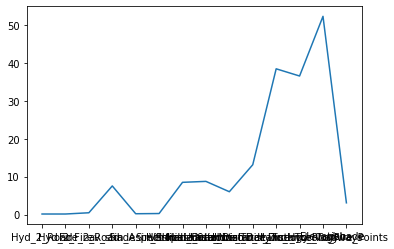

In [12]:
plt.plot(train_new[lin_feat].mean())

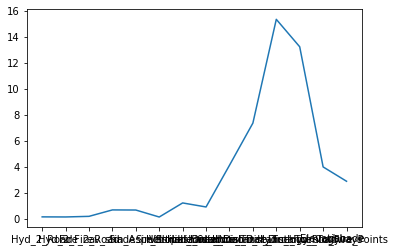

In [13]:
plt.plot(train_new[lin_feat].std())

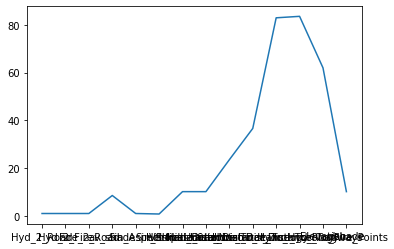

In [14]:
plt.plot(train_new[lin_feat].max())

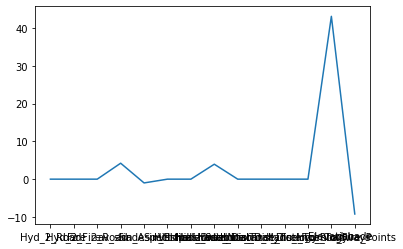

In [15]:
plt.plot(train_new[lin_feat].min())

In [16]:
train_new[lin_feat].mean()

Hyd_2_Road                             0.154970
Hyd_2_Fire                             0.155013
Fire_2_Road                            0.483857
av_shade                               7.556825
Sin_Aspect                             0.226527
Sin_Slope                              0.280699
Hillshade_9am                          8.508172
Hillshade_Noon                         8.758624
Vertical_Distance_To_Hydrology         6.030338
Horizontal_Distance_To_Hydrology      13.147964
Horizontal_Distance_To_Roadways       38.444969
Horizontal_Distance_To_Fire_Points    36.545975
Elevation                             52.281486
dshade                                 3.104492
dtype: float64

Result:
- max mean is 7;
- max value is also around 7;
- std not high and around 1 for most features;
- some standartization should be done;

Solutions:
- do scaling;
- add batchNormalization on first layer;

I added batch normalization as it is generally a good solution - it not only helps with features but can be a way to do regularization; 

In [224]:
#split
X_train, X_val, y_train, y_val = train_test_split(train_new[one_hot+lin_feat], train_new[target_col], stratify=train_new[target_col],  test_size=0.2,random_state=42)

#### Potencial standatization

robustscaler = preprocessing.RobustScaler()
stdscaler = preprocessing.StandardScaler()
minmaxscaler = preprocessing.MinMaxScaler()
maxabsscaler = preprocessing.MaxAbsScaler()
normalizer = preprocessing.Normalizer()
quantiletransformation_normal = preprocessing.QuantileTransformer(output_distribution= 'normal')
quantiletransformation_uniform = preprocessing.QuantileTransformer(output_distribution= 'uniform')
yeo_johnson = preprocessing.PowerTransformer(method= 'yeo-johnson')
box_cox = preprocessing.PowerTransformer(method= 'box-cox')

qt = QuantileTransformer(n_quantiles=7, output_distribution= 'normal')
X=qt.fit_transform(train_new[lin_feat]) 
plt.plot(np.mean(X,0))

In [225]:
#in case I would like scaling
scal=StandardScaler()
X_train_sc=scal.fit_transform(X_train[lin_feat].values)
X_val_sc=scal.transform(X_val[lin_feat].values)

#transform
X_train_sc=np.hstack([X_train_sc,X_train[one_hot]])
X_val_sc=np.hstack([X_val_sc,X_val[one_hot]])
#X_test_lin=np.hstack([X_test_lin,test[one_hot]])

### Now Neuron Network

In [21]:
import keras
import tensorflow as tf

Using TensorFlow backend.


In [22]:
from keras_radam import RAdam
from keras_radam.training import RAdamOptimizer
#RAdam(total_steps=10000, warmup_proportion=0.1, min_lr=1e-5)

In [23]:
def create_NN_class(layer_size,inputs_ker,lr,drop_ratio=0.3):
    ker_model=tf.keras.models.Sequential()
    ker_model.add(tf.keras.layers.Dense(int(layer_size), input_shape=[inputs_ker],kernel_initializer='glorot_normal',activity_regularizer=tf.keras.regularizers.l2(l=0.001)))
    #ker_model.add(tf.keras.layers.BatchNormalization())
    ker_model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
    ker_model.add(tf.keras.layers.Dropout(rate=drop_ratio))
    ker_model.add(tf.keras.layers.Dense(int(layer_size/2),activation='relu'))
    ker_model.add(tf.keras.layers.Dropout(rate=drop_ratio))
    ker_model.add(tf.keras.layers.Dense(int(layer_size/4),activation='relu'))
    ker_model.add(tf.keras.layers.Dense(7,activation='softmax')) #softmax will convert results to probabilities
    loss=tf.keras.losses.sparse_categorical_crossentropy
    #opt=tf.keras.optimizers.Adam(lr=lr,  beta_1=0.9,beta_2=0.999)
    opt=RAdamOptimizer()
    ker_model.compile(optimizer =opt,loss=loss,metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
    return ker_model

In [229]:
#all the variables
drop_ratio=0.5 #drop out is the perfect regularization and I drop 30% of neurons
batch_size=128 #the standard value
shufle=True #also good to shuffle data
inputs_ker=int(len(one_hot+lin_feat)) #that is number of inputs
verbose=1
layer_size = 600
epochs=450
lr=0.01

In [230]:
#setting up the model
model_NN_class=create_NN_class(layer_size,inputs_ker,lr=lr,drop_ratio=drop_ratio)

In [231]:
model_NN_class.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 600)               42000     
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 600)               0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_73 (Dense)             (None, 300)               180300    
_________________________________________________________________
dropout_37 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 150)               45150     
_________________________________________________________________
dense_75 (Dense)             (None, 7)               

In [232]:
#for NN to work
y_train_NN=y_train-1
y_val_NN=y_val-1
#class_weights={1: 0.37062, 2: 0.49657,3:0.05947,4:0.018,5:0.018,6:0.018,7:0.018}
class_weights_NN={0: 4, 1: 4,2:1,3:0.5,4:1,5:1,6:1}
#list_weight=compute_class_weight(class_weights,np.unique(train['Cover_Type']),train['Cover_Type'])

In [233]:
#fitting the model on train data
#model_NN_class.fit(X_train,y_train_NN,batch_size=batch_size,validation_data=(X_val,y_val_NN), epochs=epochs,verbose=verbose,shuffle=shufle,class_weight=class_weights_NN)
model_NN_class.fit(X_train_sc,y_train_NN,batch_size=batch_size,validation_data=(X_val_sc,y_val_NN), epochs=epochs,verbose=verbose,shuffle=shufle,class_weight=class_weights_NN)

Train on 12096 samples, validate on 3024 samples
Epoch 1/450
12096/12096 [==============================] - 1s 109us/sample - loss: 3.0361 - sparse_categorical_accuracy: 0.1854 - val_loss: 1.6496 - val_sparse_categorical_accuracy: 0.3363
Epoch 2/450
12096/12096 [==============================] - 1s 49us/sample - loss: 2.0694 - sparse_categorical_accuracy: 0.3968 - val_loss: 1.0161 - val_sparse_categorical_accuracy: 0.5936
Epoch 3/450
12096/12096 [==============================] - 1s 43us/sample - loss: 1.7125 - sparse_categorical_accuracy: 0.5436 - val_loss: 0.8785 - val_sparse_categorical_accuracy: 0.6511
Epoch 4/450
12096/12096 [==============================] - 1s 43us/sample - loss: 1.5607 - sparse_categorical_accuracy: 0.6007 - val_loss: 0.8067 - val_sparse_categorical_accuracy: 0.6772
Epoch 5/450
12096/12096 [==============================] - 1s 43us/sample - loss: 1.4711 - sparse_categorical_accuracy: 0.6268 - val_loss: 0.7770 - val_sparse_categorical_accuracy: 0.6865
Epoch 6/45

12096/12096 [==============================] - 1s 51us/sample - loss: 0.8058 - sparse_categorical_accuracy: 0.8269 - val_loss: 0.4928 - val_sparse_categorical_accuracy: 0.8337
Epoch 88/450
12096/12096 [==============================] - 1s 49us/sample - loss: 0.8096 - sparse_categorical_accuracy: 0.8294 - val_loss: 0.5023 - val_sparse_categorical_accuracy: 0.8360
Epoch 89/450
12096/12096 [==============================] - 1s 50us/sample - loss: 0.7896 - sparse_categorical_accuracy: 0.8327 - val_loss: 0.5040 - val_sparse_categorical_accuracy: 0.8373
Epoch 90/450
12096/12096 [==============================] - 1s 51us/sample - loss: 0.7869 - sparse_categorical_accuracy: 0.8320 - val_loss: 0.4960 - val_sparse_categorical_accuracy: 0.8350
Epoch 91/450
12096/12096 [==============================] - 1s 55us/sample - loss: 0.8065 - sparse_categorical_accuracy: 0.8303 - val_loss: 0.4917 - val_sparse_categorical_accuracy: 0.8271
Epoch 92/450
12096/12096 [==============================] - 1s 49us/

12096/12096 [==============================] - 1s 53us/sample - loss: 0.6541 - sparse_categorical_accuracy: 0.8643 - val_loss: 0.4926 - val_sparse_categorical_accuracy: 0.8502
Epoch 174/450
12096/12096 [==============================] - 1s 53us/sample - loss: 0.6701 - sparse_categorical_accuracy: 0.8610 - val_loss: 0.4955 - val_sparse_categorical_accuracy: 0.8449
Epoch 175/450
12096/12096 [==============================] - 1s 54us/sample - loss: 0.6817 - sparse_categorical_accuracy: 0.8595 - val_loss: 0.4847 - val_sparse_categorical_accuracy: 0.8532
Epoch 176/450
12096/12096 [==============================] - 1s 53us/sample - loss: 0.6635 - sparse_categorical_accuracy: 0.8609 - val_loss: 0.4983 - val_sparse_categorical_accuracy: 0.8509
Epoch 177/450
12096/12096 [==============================] - 1s 54us/sample - loss: 0.6611 - sparse_categorical_accuracy: 0.8614 - val_loss: 0.4928 - val_sparse_categorical_accuracy: 0.8502
Epoch 178/450
12096/12096 [==============================] - 1s 

12096/12096 [==============================] - 1s 50us/sample - loss: 0.6119 - sparse_categorical_accuracy: 0.8730 - val_loss: 0.5116 - val_sparse_categorical_accuracy: 0.8562
Epoch 260/450
12096/12096 [==============================] - 1s 49us/sample - loss: 0.6011 - sparse_categorical_accuracy: 0.8760 - val_loss: 0.5055 - val_sparse_categorical_accuracy: 0.8571
Epoch 261/450
12096/12096 [==============================] - 1s 51us/sample - loss: 0.6096 - sparse_categorical_accuracy: 0.8747 - val_loss: 0.4865 - val_sparse_categorical_accuracy: 0.8641
Epoch 262/450
12096/12096 [==============================] - 1s 49us/sample - loss: 0.6206 - sparse_categorical_accuracy: 0.8717 - val_loss: 0.5052 - val_sparse_categorical_accuracy: 0.8538
Epoch 263/450
12096/12096 [==============================] - 1s 48us/sample - loss: 0.5993 - sparse_categorical_accuracy: 0.8780 - val_loss: 0.5133 - val_sparse_categorical_accuracy: 0.8489
Epoch 264/450
12096/12096 [==============================] - 1s 

12096/12096 [==============================] - 1s 43us/sample - loss: 0.5832 - sparse_categorical_accuracy: 0.8844 - val_loss: 0.5091 - val_sparse_categorical_accuracy: 0.8588
Epoch 346/450
12096/12096 [==============================] - 1s 50us/sample - loss: 0.5881 - sparse_categorical_accuracy: 0.8812 - val_loss: 0.5237 - val_sparse_categorical_accuracy: 0.8618
Epoch 347/450
12096/12096 [==============================] - 1s 43us/sample - loss: 0.5659 - sparse_categorical_accuracy: 0.8814 - val_loss: 0.5196 - val_sparse_categorical_accuracy: 0.8568
Epoch 348/450
12096/12096 [==============================] - 1s 45us/sample - loss: 0.5659 - sparse_categorical_accuracy: 0.8854 - val_loss: 0.5141 - val_sparse_categorical_accuracy: 0.8578
Epoch 349/450
12096/12096 [==============================] - 1s 44us/sample - loss: 0.5917 - sparse_categorical_accuracy: 0.8784 - val_loss: 0.5304 - val_sparse_categorical_accuracy: 0.8525
Epoch 350/450
12096/12096 [==============================] - 1s 

12096/12096 [==============================] - 1s 43us/sample - loss: 0.5388 - sparse_categorical_accuracy: 0.8899 - val_loss: 0.5291 - val_sparse_categorical_accuracy: 0.8618
Epoch 432/450
12096/12096 [==============================] - 1s 43us/sample - loss: 0.5426 - sparse_categorical_accuracy: 0.8924 - val_loss: 0.5188 - val_sparse_categorical_accuracy: 0.8654
Epoch 433/450
12096/12096 [==============================] - 1s 43us/sample - loss: 0.5417 - sparse_categorical_accuracy: 0.8869 - val_loss: 0.5332 - val_sparse_categorical_accuracy: 0.8631
Epoch 434/450
12096/12096 [==============================] - 1s 43us/sample - loss: 0.5297 - sparse_categorical_accuracy: 0.8913 - val_loss: 0.5277 - val_sparse_categorical_accuracy: 0.8575
Epoch 435/450
12096/12096 [==============================] - 1s 43us/sample - loss: 0.5331 - sparse_categorical_accuracy: 0.8948 - val_loss: 0.5314 - val_sparse_categorical_accuracy: 0.8628
Epoch 436/450
12096/12096 [==============================] - 1s 

In [234]:
NN_pred_prob=model_NN_class.predict(X_val_sc)
NN_pred=np.argmax(NN_pred_prob,1)
bal_acc(y_val_NN.values,NN_pred,weights=list_weight)

(0.7736183101851852, 0.8634259259259258)

drop_ratio=0.5 #drop out is the perfect regularization and I drop 30% of neurons
batch_size=128 #the standard value
layer_size = 600
epochs=450
lr=0.01
class_weights_NN={0: 4, 1: 4,2:1,3:0.5,4:1,5:1,6:1}

with scalling  (0.7736183101851852, 0.8634259259259258)


In [235]:
confusion_matrix(y_val_NN.values, NN_pred)

array([[354,  63,   1,   0,   4,   1,   9],
       [ 71, 308,  10,   0,  25,  14,   4],
       [  0,   3, 359,   7,   9,  54,   0],
       [  0,   0,  13, 414,   0,   5,   0],
       [  9,  19,   6,   0, 392,   6,   0],
       [  2,   6,  27,   2,   1, 394,   0],
       [ 39,   3,   0,   0,   0,   0, 390]], dtype=int64)

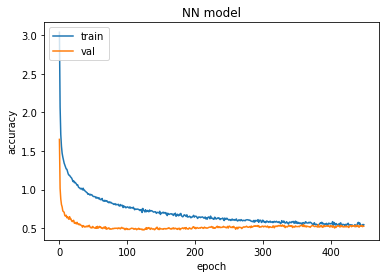

In [236]:
plt.plot(model_NN_class.history.history['loss'])
plt.plot(model_NN_class.history.history['val_loss'])
plt.title('NN model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Stratified fitting

The idea is that I will also use bagging but the way to do it in this case - fit some more epochs so that dependncy on luck in selecting epochs is minimized

In [17]:
from sklearn.model_selection import StratifiedKFold

In [24]:
def train_NN(data_train,data_val,one_hot,lin_feat,target_col,verbose_NN=0,bagg=5):
    #imput is data in pandas DataFrame with learn columns and target columns
    #scaling
    scal=StandardScaler()
    X_train_sc=scal.fit_transform(data_train[lin_feat])
    X_val_sc=scal.transform(data_val[lin_feat])
    #add one-hot
    X_train_sc=np.hstack([X_train_sc,data_train[one_hot]])
    X_val_sc=np.hstack([X_val_sc,data_val[one_hot]])
    #y labels
    y_train_NN=data_train[target_col].values-1
    #y_val_NN=data_val[target_col].values-1
    #setting up the model
    model_NN=create_NN_class(layer_size= 600,inputs_ker=int(len(one_hot+lin_feat)),lr=0.01,drop_ratio=0.5)
    #fitting with some weights
    class_weights_NN={0: 4, 1: 4,2:1,3:0.5,4:1,5:1,6:1}
    #fitting the model on train data
    model_NN.fit(X_train_sc,y_train_NN,batch_size=128, epochs=450,verbose=0,shuffle=True,class_weight=class_weights_NN)
    temp_result=[]
    temp_result.append(model_NN.predict_proba(X_val_sc))
    for i in range(bagg-1):
        print('submodel_fit ',i)
        epochs_bag=10
        model_NN.fit(X_train_sc,y_train_NN,batch_size=128, epochs=epochs_bag,verbose=0,shuffle=True,class_weight=class_weights_NN)
        temp_result.append(model_NN.predict_proba(X_val_sc))
    NN_model_prob=np.mean(temp_result,axis=0)
    return NN_model_prob

In [25]:
skf_2 = StratifiedKFold(n_splits=5,shuffle=True)
result=pd.DataFrame(np.zeros([train_new.shape[0],7]))

In [26]:
i=0
for train_index, test_index in skf_2.split(train_new[one_hot+lin_feat],train_new[target_col]):
    data_train=train_new.iloc[train_index,:]
    data_val=train_new.iloc[test_index,:]
    result.iloc[test_index,:]=train_NN(data_train,data_val,one_hot,lin_feat,target_col)
    print('stage done ',i)
    i+=1

W0917 10:04:10.365543 15004 deprecation.py:323] From C:\Users\Dopefish\Anaconda3\envs\TF2\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


submodel_fit  0
submodel_fit  1
submodel_fit  2
submodel_fit  3
stage done  0
submodel_fit  0
submodel_fit  1
submodel_fit  2
submodel_fit  3
stage done  1
submodel_fit  0
submodel_fit  1
submodel_fit  2
submodel_fit  3
stage done  2
submodel_fit  0
submodel_fit  1
submodel_fit  2
submodel_fit  3
stage done  3
submodel_fit  0
submodel_fit  1
submodel_fit  2
submodel_fit  3
stage done  4


In [27]:
predic=np.argmax(result.values,1)+1

In [28]:
#the accuracy of validation
print("acc is: ",accuracy_score(train_new[target_col].values,predic))
print("special acc is: ",bal_acc(train_new[target_col].values,predic,weights=list_weight))

acc is:  0.8728174603174603
special acc is:  (0.7926306018518519, 0.8728174603174602)


acc is:  0.8728174603174603
special acc is:  (0.7926306018518519, 0.8728174603174602)

In [30]:
confusion_matrix(train_new[target_col].values,predic)

array([[1700,  344,    2,    0,   26,    3,   85],
       [ 310, 1669,   28,    0,  101,   37,   15],
       [   1,   35, 1796,   68,   23,  237,    0],
       [   0,    0,   81, 2040,    0,   39,    0],
       [  19,   91,   22,    0, 2001,   26,    1],
       [   7,   22,  140,   29,    9, 1953,    0],
       [ 107,   15,    0,    0,    0,    0, 2038]], dtype=int64)

In [31]:
result.to_csv('NN_train_prob.csv')

### Full Data fit

In [32]:
test=pd.read_csv(os.path.join(os.getcwd(),'test.csv.zip'))
test_new=add_lin(test,soil_type,soil_names,hill_feat)

In [33]:
result_final_NN=train_NN(train_new,test_new,one_hot,lin_feat,target_col,verbose_NN=0)

submodel_fit  0
submodel_fit  1
submodel_fit  2
submodel_fit  3


In [34]:
result_final_NN=pd.DataFrame(result_final_NN,index=test.Id.values)

In [35]:
result_final_NN.to_csv('NN_test_prob.csv')

### Submission

In [256]:
sub=pd.DataFrame(test.Id.values,columns=['ID'])
pred_test=np.argmax(result_final_NN.values,axis=1)+1
sub['Cover_Type']=pred_test.astype('int64')
sub.to_csv('NN_tuned.csv',index=False)

submission result 0.79252